In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# append the filepath to where torch is installed
sys.path.append('/home/millerm/.local/lib/python3.10/site-packages')
# sys.path.append('/home/username/.local/lib/python3.10/site-packages')

import torch
import torch.nn as nn
import torch.optim as optim

## Load and Preprocess Data

In [2]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_train.csv"
df_train = pd.read_csv(file_name,header=None)
x_train = df_train.iloc[:, df_train.columns != 187]
x_train = x_train.values.reshape(-1, 1, 187)
train_target = df_train.iloc[:, 187]
train_target = train_target.values
np.unique(train_target,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([72471,  2223,  5788,   641,  6431]))

In [3]:
file_name = "ml4h_data/project2/project2_TS_input/mitbih_test.csv"
df_test = pd.read_csv(file_name,header=None)
x_test = df_test.iloc[:, df_test.columns != 187]
x_test = x_test.values.reshape(-1, 1, 187)
test_target = df_test.iloc[:, 187]
test_target = test_target.values
np.unique(test_target,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([18118,   556,  1448,   162,  1608]))

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
from setsloaders import create_datasets, create_loaders

In [6]:
datasets = create_datasets(x_train, x_test, train_target, test_target, seed=123)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

## Load and Train Model

In [7]:
input_channels = 1
num_classes = 5
train_loader = trn_dl
test_loader = tst_dl
num_epochs = 30
learning_rate = 0.005

In [8]:
class cnn(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.fc1 = nn.Linear(5376, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = cnn(input_channels, num_classes).to(device)

In [9]:
model = torch.load("models/vanillacnn.pth")
model = model.to(device)

In [10]:
model.fc2 = nn.Linear(128, 5, bias=True).to(device)

In [11]:
print(model)

cnn(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss}")
        
model.eval()
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(predicted,labels)
        predicted = predicted.to("cpu")
        predictions = np.append(predictions,predicted)

    accuracy = 100 * correct / total
    print('Accuracy: {:.2f}%'.format(accuracy))

Epoch: 0, Loss: 0.06035562604665756
Epoch: 1, Loss: 0.07411456108093262
Epoch: 2, Loss: 0.03483486920595169
Epoch: 3, Loss: 0.057375580072402954
Epoch: 4, Loss: 0.1295066475868225
Epoch: 5, Loss: 0.04020923748612404
Epoch: 6, Loss: 0.04918348789215088
Epoch: 7, Loss: 0.026485299691557884
Epoch: 8, Loss: 0.024512602016329765
Epoch: 9, Loss: 0.015727488324046135
Epoch: 10, Loss: 0.043743912130594254
Epoch: 11, Loss: 0.016276879236102104
Epoch: 12, Loss: 0.006542561575770378
Epoch: 13, Loss: 0.0055747791193425655
Epoch: 14, Loss: 0.035218674689531326
Epoch: 15, Loss: 0.0031519935000687838
Epoch: 16, Loss: 0.020512163639068604
Epoch: 17, Loss: 0.03547593951225281
Epoch: 18, Loss: 0.04987310990691185
Epoch: 19, Loss: 0.025958525016903877
Epoch: 20, Loss: 0.025782501325011253
Epoch: 21, Loss: 0.0058400980196893215
Epoch: 22, Loss: 0.00981922261416912
Epoch: 23, Loss: 0.0010112394811585546
Epoch: 24, Loss: 0.05216825008392334
Epoch: 25, Loss: 0.0026923860423266888
Epoch: 26, Loss: 0.001660183

In [17]:
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

precision = precision_score(ground_truth, predictions, average="macro")
recall = recall_score(ground_truth, predictions, average="macro")
f1 = f1_score(ground_truth, predictions, average="macro")

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1-Score: {:.2f}'.format(f1))

Precision: 0.94
Recall: 0.86
F1-Score: 0.90


In [14]:
torch.save(model, "models/transfercnn.pth")

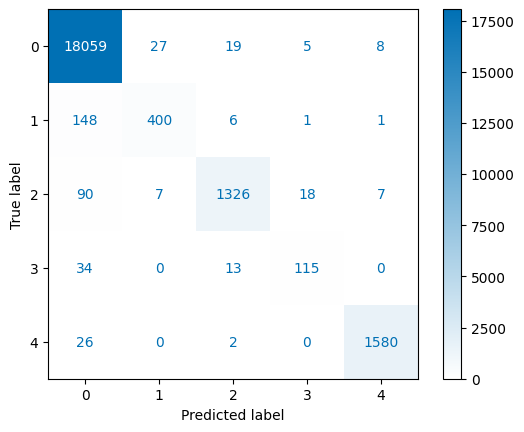

In [15]:
default_cmap = LinearSegmentedColormap.from_list('zurichblue',
                                                 [(0, '#ffffff'),
                                                  (1, '#0070b4')], N=256)
cm = confusion_matrix(test_target, predictions)
ConfusionMatrixDisplay(cm).plot(cmap=default_cmap)
plt.savefig("plots/conmat_transfer.png")